In [19]:
import pandas as pd
import matplotlib.pyplot as plt
import xgboost as xgb
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [3]:
data=pd.read_csv('sales_data_sample.csv', encoding='latin1')

In [7]:
data.head()

,ORDERNUMBER,QUANTITYORDERED,PRICEEACH,ORDERLINENUMBER,SALES,ORDERDATE,STATUS,QTR_ID,MONTH_ID,YEAR_ID,...,ADDRESSLINE1,ADDRESSLINE2,CITY,STATE,POSTALCODE,COUNTRY,TERRITORY,CONTACTLASTNAME,CONTACTFIRSTNAME,DEALSIZE
0,10107,30,95.70,2,2871.00,2/24/2003 0:00,Shipped,1,2,2003,...,897 Long Airport Avenue,NaN,NYC,NY,10022,USA,NaN,Yu,Kwai,Small
1,10121,34,81.35,5,2765.90,5/7/2003 0:00,Shipped,2,5,2003,...,59 rue de l'Abbaye,NaN,Reims,NaN,51100,France,EMEA,Henriot,Paul,Small
2,10134,41,94.74,2,3884.34,7/1/2003 0:00,Shipped,3,7,2003,...,27 rue du Colonel Pierre Avia,NaN,Paris,NaN,75508,France,EMEA,Da Cunha,Daniel,Medium
3,10145,45,83.26,6,3746.70,8/25/2003 0:00,Shipped,3,8,2003,...,78934 Hillside Dr.,NaN,Pasadena,CA,90003,USA,NaN,Young,Julie,Medium
4,10159,49,100.00,14,5205.27,10/10/2003 0:00,Shipped,4,10,2003,...,7734 Strong St.,NaN,San Francisco,CA,NaN,USA,NaN,Brown,Julie,Medium


In [11]:
sum(data['SALES'])

10032628.85

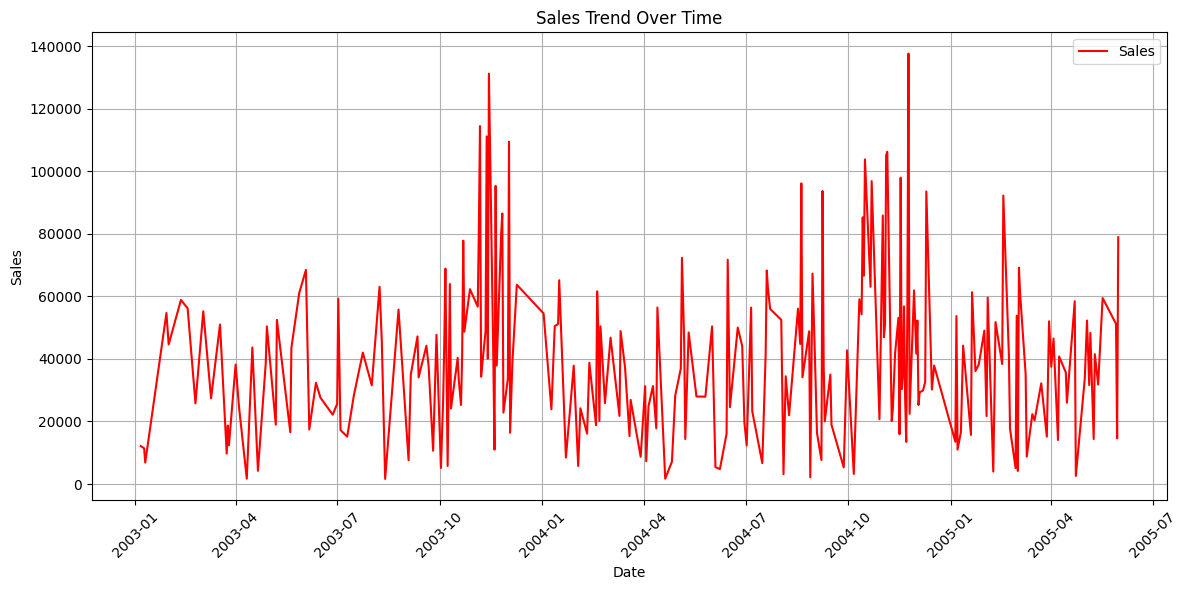

In [15]:
data['ORDERDATE'] = pd.to_datetime(data['ORDERDATE'], format='%m/%d/%Y %H:%M')

sales_by_date = data.groupby('ORDERDATE')['SALES'].sum().reset_index()

plt.figure(figsize=(12, 6))
plt.plot(sales_by_date['ORDERDATE'], sales_by_date['SALES'], label='Sales', color='red')
plt.title('Sales Trend Over Time')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.grid(True)
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [16]:
def create_lagged_features(data, lag=1):
    lagged_data = data.copy()
    for i in range(1, lag+1):
        lagged_data[f'lag_{i}'] = lagged_data['SALES'].shift(i)
    return lagged_data

lag = 5  
sales_with_lags = create_lagged_features(data[['ORDERDATE', 'SALES']], lag)

sales_with_lags = sales_with_lags.dropna()

In [17]:
X = sales_with_lags.drop(columns=['ORDERDATE', 'SALES'])
y = sales_with_lags['SALES']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

In [18]:
model_xgb = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, learning_rate=0.1, max_depth=5)
model_xgb.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.1, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=100,
             n_jobs=None, num_parallel_tree=None, ...)

In [20]:
predictions_xgb = model_xgb.predict(X_test)
rmse_xgb = np.sqrt(mean_squared_error(y_test, predictions_xgb))

print(f"RMSE: {rmse_xgb:.2f}")

RMSE: 1263.96


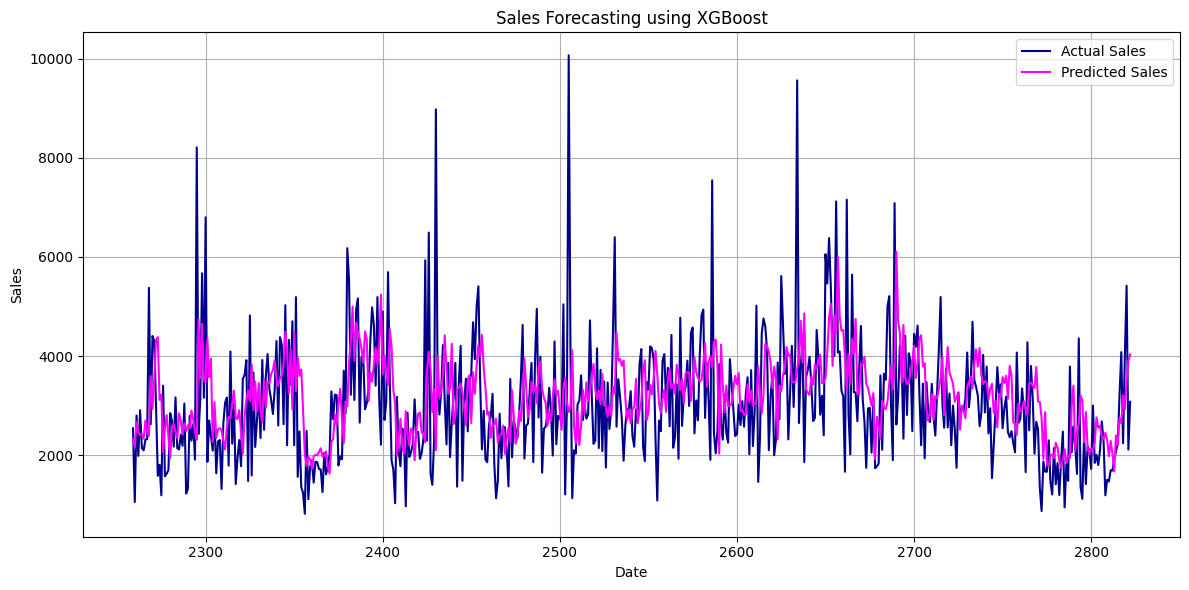

In [36]:
plt.figure(figsize=(12, 6))
plt.plot(y_test.index, y_test, label='Actual Sales', color='darkblue')
plt.plot(y_test.index, predictions_xgb, label='Predicted Sales', color='magenta')
plt.title('Sales Forecasting using XGBoost')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [43]:
last_known_sales = sales_with_lags['SALES'].values[-lag:]

In [44]:
future_preds = []

In [46]:
for i in range(12):  
    
    x_input = last_known_sales[-lag:].reshape(1, -1)  # shape (1, lag)
    next_pred = model_xgb.predict(x_input)[0]
    future_preds.append(next_pred)
    last_known_sales = np.append(last_known_sales, next_pred)

In [47]:
future_dates = pd.date_range(start=data['ORDERDATE'].max() + pd.DateOffset(months=1), periods=12, freq='M')

C:\Users\feelh\AppData\Local\Temp\ipykernel_27424\1654278255.py:1: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  future_dates = pd.date_range(start=data['ORDERDATE'].max() + pd.DateOffset(months=1), periods=12, freq='M')


In [48]:
forecast_df = pd.DataFrame({
    'ORDERDATE': future_dates,
    'SALES': future_preds
})

In [49]:
forecast_df.to_csv('sales_forecast_next_year.csv', index=False)

In [50]:
forecast_df

,ORDERDATE,SALES
0,2005-06-30,3627.267578
1,2005-07-31,4448.879883
2,2005-08-31,3604.262695
3,2005-09-30,3527.321533
4,2005-10-31,3334.469727
5,2005-11-30,3737.853271
6,2005-12-31,3024.210938
7,2006-01-31,3641.457764
8,2006-02-28,3420.428711
9,2006-03-31,3898.070068


In [51]:
monthly_sales = data.groupby(pd.Grouper(key='ORDERDATE', freq='M'))['SALES'].sum().reset_index()

C:\Users\feelh\AppData\Local\Temp\ipykernel_27424\2976968528.py:1: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_sales = data.groupby(pd.Grouper(key='ORDERDATE', freq='M'))['SALES'].sum().reset_index()


In [52]:
def create_lagged_features_monthly(df, lag=1):
    lagged = df.copy()
    for i in range(1, lag+1):
        lagged[f'lag_{i}'] = lagged['SALES'].shift(i)
    return lagged

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import xgboost as xgb
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [ ]:
data=pd.read_csv('sales_data_sample.csv', encoding='latin1')

In [ ]:
data.head()

,ORDERNUMBER,QUANTITYORDERED,PRICEEACH,ORDERLINENUMBER,SALES,ORDERDATE,STATUS,QTR_ID,MONTH_ID,YEAR_ID,...,ADDRESSLINE1,ADDRESSLINE2,CITY,STATE,POSTALCODE,COUNTRY,TERRITORY,CONTACTLASTNAME,CONTACTFIRSTNAME,DEALSIZE
0,10107,30,95.70,2,2871.00,2/24/2003 0:00,Shipped,1,2,2003,...,897 Long Airport Avenue,NaN,NYC,NY,10022,USA,NaN,Yu,Kwai,Small
1,10121,34,81.35,5,2765.90,5/7/2003 0:00,Shipped,2,5,2003,...,59 rue de l'Abbaye,NaN,Reims,NaN,51100,France,EMEA,Henriot,Paul,Small
2,10134,41,94.74,2,3884.34,7/1/2003 0:00,Shipped,3,7,2003,...,27 rue du Colonel Pierre Avia,NaN,Paris,NaN,75508,France,EMEA,Da Cunha,Daniel,Medium
3,10145,45,83.26,6,3746.70,8/25/2003 0:00,Shipped,3,8,2003,...,78934 Hillside Dr.,NaN,Pasadena,CA,90003,USA,NaN,Young,Julie,Medium
4,10159,49,100.00,14,5205.27,10/10/2003 0:00,Shipped,4,10,2003,...,7734 Strong St.,NaN,San Francisco,CA,NaN,USA,NaN,Brown,Julie,Medium


In [ ]:
sum(data['SALES'])

10032628.85

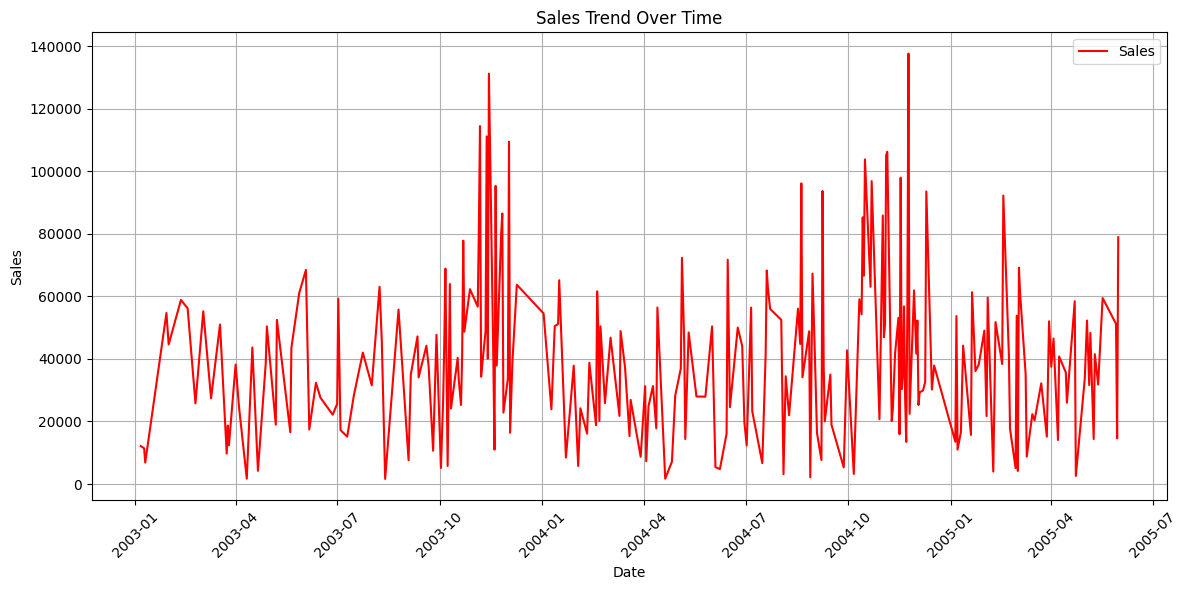

In [ ]:
data['ORDERDATE'] = pd.to_datetime(data['ORDERDATE'], format='%m/%d/%Y %H:%M')

sales_by_date = data.groupby('ORDERDATE')['SALES'].sum().reset_index()

plt.figure(figsize=(12, 6))
plt.plot(sales_by_date['ORDERDATE'], sales_by_date['SALES'], label='Sales', color='red')
plt.title('Sales Trend Over Time')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.grid(True)
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
def create_lagged_features(data, lag=1):
    lagged_data = data.copy()
    for i in range(1, lag+1):
        lagged_data[f'lag_{i}'] = lagged_data['SALES'].shift(i)
    return lagged_data

lag = 5  
sales_with_lags = create_lagged_features(data[['ORDERDATE', 'SALES']], lag)

sales_with_lags = sales_with_lags.dropna()

In [ ]:
X = sales_with_lags.drop(columns=['ORDERDATE', 'SALES'])
y = sales_with_lags['SALES']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

In [ ]:
model_xgb = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, learning_rate=0.1, max_depth=5)
model_xgb.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.1, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=100,
             n_jobs=None, num_parallel_tree=None, ...)

In [ ]:
predictions_xgb = model_xgb.predict(X_test)
rmse_xgb = np.sqrt(mean_squared_error(y_test, predictions_xgb))

print(f"RMSE: {rmse_xgb:.2f}")

RMSE: 1263.96


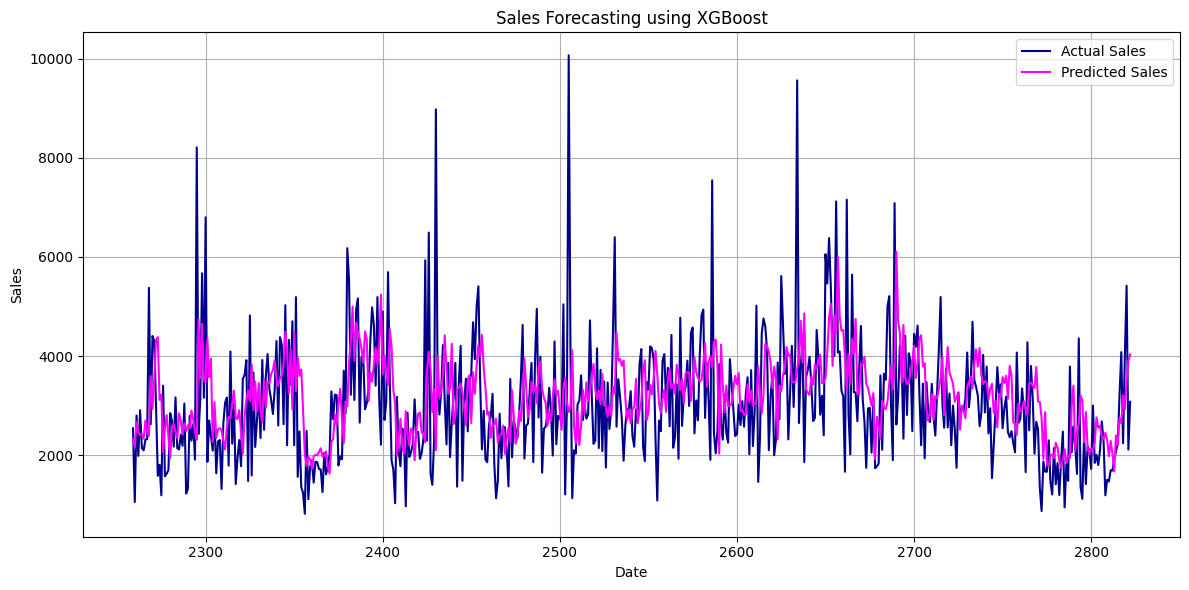

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(y_test.index, y_test, label='Actual Sales', color='darkblue')
plt.plot(y_test.index, predictions_xgb, label='Predicted Sales', color='magenta')
plt.title('Sales Forecasting using XGBoost')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [56]:
# 1. Aggregate sales by month
monthly_sales = data.groupby(pd.Grouper(key='ORDERDATE', freq='M'))['SALES'].sum().reset_index()

# 2. Create lag features on monthly data
def create_lagged_features_monthly(df, lag=1):
    lagged = df.copy()
    for i in range(1, lag+1):
        lagged[f'lag_{i}'] = lagged['SALES'].shift(i)
    return lagged

lag = 5
monthly_with_lags = create_lagged_features_monthly(monthly_sales, lag)
monthly_with_lags = monthly_with_lags.dropna()

X = monthly_with_lags.drop(columns=['ORDERDATE', 'SALES'])
y = monthly_with_lags['SALES']

# Split train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Train XGBoost
model_xgb = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, learning_rate=0.1, max_depth=5)
model_xgb.fit(X_train, y_train)

# Predict next 12 months iteratively
last_known_sales = monthly_with_lags['SALES'].values[-lag:]
future_preds = []

for i in range(12):
    x_input = last_known_sales[-lag:].reshape(1, -1)
    next_pred = model_xgb.predict(x_input)[0]
    future_preds.append(next_pred)
    last_known_sales = np.append(last_known_sales, next_pred)

# Create future dates at month-end
future_dates = pd.date_range(start=monthly_sales['ORDERDATE'].max() + pd.DateOffset(months=1), periods=12, freq='M')

forecast_df = pd.DataFrame({
    'ORDERDATE': future_dates,
    'SALES': future_preds
})

forecast_df.to_csv('monthly_sales_forecast.csv', index=False)
forecast_df


C:\Users\feelh\AppData\Local\Temp\ipykernel_27424\3588650386.py:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_sales = data.groupby(pd.Grouper(key='ORDERDATE', freq='M'))['SALES'].sum().reset_index()
C:\Users\feelh\AppData\Local\Temp\ipykernel_27424\3588650386.py:36: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  future_dates = pd.date_range(start=monthly_sales['ORDERDATE'].max() + pd.DateOffset(months=1), periods=12, freq='M')


,ORDERDATE,SALES
0,2005-06-30,4.039058e+05
1,2005-07-31,3.059177e+05
2,2005-08-31,5.198362e+05
3,2005-09-30,2.740100e+05
4,2005-10-31,3.182962e+05
5,2005-11-30,5.354255e+05
6,2005-12-31,2.925525e+05
7,2006-01-31,9.482172e+05
8,2006-02-28,3.084441e+05
9,2006-03-31,3.001966e+05


In [55]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

monthly_sales = data.groupby(pd.Grouper(key='ORDERDATE', freq='M'))['SALES'].sum()
model = ExponentialSmoothing(monthly_sales, trend='add', seasonal='add', seasonal_periods=12).fit()
forecast = model.forecast(12)

forecast_df = pd.DataFrame({
    'ORDERDATE': pd.date_range(start=monthly_sales.index[-1]+pd.DateOffset(months=1), periods=12, freq='M'),
    'SALES': forecast.values
})
forecast_df.to_csv('monthly_sales_forecast1.csv', index=False)
forecast_df

C:\Users\feelh\AppData\Local\Temp\ipykernel_27424\749056855.py:3: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_sales = data.groupby(pd.Grouper(key='ORDERDATE', freq='M'))['SALES'].sum()
c:\Users\feelh\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\feelh\AppData\Local\Temp\ipykernel_27424\749056855.py:8: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  'ORDERDATE': pd.date_range(start=monthly_sales.index[-1]+pd.DateOffset(months=1), periods=12, freq='M'),


,ORDERDATE,SALES
0,2005-06-30,3.650795e+05
1,2005-07-31,3.750446e+05
2,2005-08-31,4.056202e+05
3,2005-09-30,4.254227e+05
4,2005-10-31,7.190786e+05
5,2005-11-30,1.200404e+06
6,2005-12-31,4.433095e+05
7,2006-01-31,4.588203e+05
8,2006-02-28,4.579419e+05
9,2006-03-31,3.938155e+05
